### Import libraries

In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

### Global variables

In [5]:
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
raw_data_directory = "../data/raw/"
unzip_directory = "../data/unzip"
combined_directory = "../data/combined"
files_to_dl = ["data.zip"]
dtypes = {
    "lat_min": "float32",
    "lat_max": "float32",
    "lon_min": "float32",
    "lon_max": "float32",
    "rain (mm/day)": "float32",
    "model": "str",
}

### Check files from API

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

### 3.1 Download file

In [4]:
%%time
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(raw_data_directory, exist_ok=True)
        urlretrieve(file["download_url"], raw_data_directory + file["name"])

CPU times: user 5.66 s, sys: 4.85 s, total: 10.5 s
Wall time: 1min 30s


### 3.2 Unzip the file

In [5]:
%%time
os.makedirs(unzip_directory, exist_ok=True)
with zipfile.ZipFile(os.path.join(raw_data_directory, "data.zip"), 'r') as f:
    f.extractall(unzip_directory)

CPU times: user 14.9 s, sys: 1.32 s, total: 16.2 s
Wall time: 16.5 s


### 4.0 Remove unnecessary csv

In [6]:
os.remove(unzip_directory + "/observed_daily_rainfall_SYD.csv")

### 4.1 Merge files

In [7]:
%%time
files = glob.glob(unzip_directory + '/*.csv')
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=re.findall(r'(?<=unzip\/).+(?=_daily)', file)[0])
                for file in files)
              )
os.makedirs(combined_directory, exist_ok=True)
df.to_csv(combined_directory + "/combined_data.csv")

CPU times: user 6min 6s, sys: 8.24 s, total: 6min 14s
Wall time: 6min 17s


In [8]:
%%sh
du -sh ../data/combined/combined_data.csv

5.6G	../data/combined/combined_data.csv


### 4.2 Time comparison of merging files

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Arushi Ahuja|                  |     |           |        |            |
| Dongxiao Li |                  |     |           |        |            |
| Simon Guo   | MacOS | 16GB | Apple M1 | Yes |    6min 17s      |
| Thomas Siu  | MacOS | 16GB | Apple M1 | Yes |    6min 30s        |


summarize the observations

### 5.1 Load the combined csv

In [9]:
%%time
df = pd.read_csv(combined_directory + "/combined_data.csv", parse_dates=['time'])

CPU times: user 1min 4s, sys: 6.96 s, total: 1min 11s
Wall time: 1min 15s


### 5.2 Time comparison of loading the combined csv

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Arushi Ahuja|                  |     |           |        |            |
| Dongxiao Li |                  |     |           |        |            |
| Simon Guo   | MacOS | 16GB | Apple M1 | Yes |  1min 15s      |
| Thomas Siu  | MacOS | 16GB | Apple M1 | Yes |  1min          |

summarize the observations

In [12]:
df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
2,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
3,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
4,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


### 5.3 EDA

In [13]:
df.shape

(62467843, 7)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62467843 entries, 0 to 62467842
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   time           datetime64[ns]
 1   lat_min        float64       
 2   lat_max        float64       
 3   lon_min        float64       
 4   lon_max        float64       
 5   rain (mm/day)  float64       
 6   model          object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 3.3+ GB


### 6.1 Import R libraries

In [2]:
%load_ext rpy2.ipython

// Run it in console in 525 environment

conda install -c conda-forge r-dplyr

// Uncomment and run the following block if ggplot2 not installed

In [7]:
#%%R
#install.packages(ggplot2)

In [3]:
%%R
suppressMessages(library(arrow, warn.conflicts = FALSE))
suppressMessages(library(dplyr, warn.conflicts = FALSE))
suppressMessages(library(ggplot2, warn.conflicts = FALSE))

### 6.2 Load data

In [18]:
df.to_parquet(combined_directory + "/combined_data.parquet")

In [6]:
%%R -i combined_directory

open_dataset(paste0(combined_directory, "/combined_data.parquet")) %>%
  select("time", "rain (mm/day)") %>%
  collect() %>%
  nrow()

[1] 62467843


We have over 62 million rows! That is a lot of data for R to handle, and we will do some simple EDA to have some basic understanding of the data

### 6.3 EDA in R

In [12]:
%%time
%%R -i combined_directory

df <- open_dataset(paste0(combined_directory, "/combined_data.parquet")) %>%
  select("time", "rain (mm/day)") %>%
  collect()

summary(df)

      time                     rain (mm/day)    
 Min.   :1888-12-31 16:00:00   Min.   :  0      
 1st Qu.:1920-07-02 04:00:00   1st Qu.:  0      
 Median :1952-01-01 04:00:00   Median :  0      
 Mean   :1952-01-01 08:32:08   Mean   :  2      
 3rd Qu.:1983-07-02 05:00:00   3rd Qu.:  1      
 Max.   :2014-12-31 04:00:00   Max.   :433      
                               NA's   :3219300  
CPU times: user 1min, sys: 2.14 s, total: 1min 2s
Wall time: 1min 1s


In [12]:
%%time
%%R -i combined_directory

df <- open_dataset(paste0(combined_directory, "/combined_data.parquet")) %>%
  select(time, model) %>%
  collect() %>%
  group_by(model) %>%
  summarise(n = n()) %>%
  mutate(Freq = n/sum(n)) %>%
  arrange(desc(Freq))

# A tibble: 27 × 3
   model               n   Freq
   <chr>           <int>  <dbl>
 1 MPI-ESM1-2-HR 5154240 0.0825
 2 CMCC-CM2-HR4  3541230 0.0567
 3 CMCC-CM2-SR5  3541230 0.0567
 4 CMCC-ESM2     3541230 0.0567
 5 NorESM2-MM    3541230 0.0567
 6 TaiESM1       3541230 0.0567
 7 SAM0-UNICON   3541153 0.0567
 8 FGOALS-f3-L   3219300 0.0515
 9 GFDL-CM4      3219300 0.0515
10 GFDL-ESM4     3219300 0.0515
# … with 17 more rows
CPU times: user 4.31 s, sys: 1.59 s, total: 5.9 s
Wall time: 5.1 s


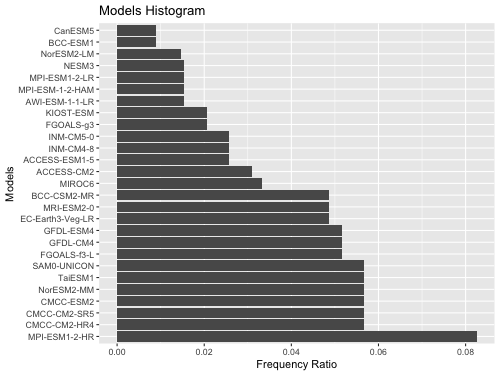

In [23]:
%%R -w 500 -h 375

df %>%
  ggplot(aes(x = Freq, y = reorder(model, -n))) +
  geom_bar(stat = 'identity') +
  labs(x = "Frequency Ratio", y = "Models", title = "Models Histogram")

### 6.4 Discussions

Discuss why you chose this approach over others.

- [Parquet file](http://parquet.apache.org) and 
    - As mentioned in class, most of the time is spent on the serialization and de-serialization process.
- [Feather file](https://arrow.apache.org/docs/python/feather.html)
- [Pandas exchange](https://rpy2.github.io/doc/latest/html/interactive.html)
- [Arrow exchange](https://github.com/rpy2/rpy2-arrow)
    - Arrow with parquet is the way to go; as it does not leverage the power of parquet format to make the loading process faster, but it also uses the arrow format to reduce the time spent on converting in between python and R data

### 7. Challenges and Difficulties

Discuss any challenges or difficulties you faced when dealing with this large amount of data on your laptops. Briefly explain your approach to overcome the challenges or reasons why you could not overcome them.